# 02-Titanic data with scikit learn

https://towardsdatascience.com/interactive-visualization-of-decision-trees-with-jupyter-widgets-ca15dd312084

## Setup libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn
import sklearn

In [3]:
import graphviz

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [5]:
%load_ext autoreload
%autoreload 2

## Get data

In [6]:
url = "https://raw.github.com/mattdelhey/kaggle-titanic/master/Data/train.csv"
titanic_raw = pd.read_csv(url)
titanic_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   survived  891 non-null    int64  
 1   pclass    891 non-null    int64  
 2   name      891 non-null    object 
 3   sex       891 non-null    object 
 4   age       714 non-null    float64
 5   sibsp     891 non-null    int64  
 6   parch     891 non-null    int64  
 7   ticket    891 non-null    object 
 8   fare      891 non-null    float64
 9   cabin     204 non-null    object 
 10  embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


## Clean data

Missing value counts

In [7]:
titanic_raw.isna().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

Drop missing data rows

In [8]:
df = titanic_raw
cols = ['survived', 'pclass', 'sex', 'age']
titanic_raw2 = titanic_raw[~titanic_raw.age.isna()][cols]

In [9]:
titanic_raw2.describe(include='all')

,survived,pclass,sex,age
count,714.000000,714.000000,714,714.000000
unique,NaN,NaN,2,NaN
top,NaN,NaN,male,NaN
freq,NaN,NaN,453,NaN
mean,0.406162,2.236695,NaN,29.699118
std,0.491460,0.838250,NaN,14.526497
min,0.000000,1.000000,NaN,0.420000
25%,0.000000,1.000000,NaN,20.125000
50%,0.000000,2.000000,NaN,28.000000
75%,1.000000,3.000000,NaN,38.000000


Get types of columns

In [10]:
titanic = titanic_raw2.astype({
    'survived': 'category',
    'pclass': 'category',
    'sex': 'category',
    'age': 'int16'
})

List of classes on the Titanic

In [11]:
titanic.pclass.value_counts()

3    355
1    186
2    173
Name: pclass, dtype: int64

In [12]:
titanic.sex.value_counts()

male      453
female    261
Name: sex, dtype: int64

In [13]:
sex_encoder = LabelEncoder()
titanic['sex'] = sex_encoder.fit_transform(titanic.sex)

In [14]:
X_train = titanic.drop('survived', axis=1)
y_train = titanic['survived']

## Model survival using logistic regression

Logistic regression

In [15]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
logreg.score(X_train, y_train) * 100

78.99159663865547

In [17]:
coef = pd.Series(titanic.columns.delete(0)).to_frame('feature')
coef['coef'] = logreg.coef_[0]
coef

,feature,coef
0,pclass,-1.249010
1,sex,-2.412749
2,age,-0.036109


## Model survival using decision trees

In [18]:
decision_tree = DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [19]:
decision_tree.score(X_train, y_train) * 100

80.812324929972

In [20]:
decision_tree.n_features_

3

In [22]:
features = pd.Series(titanic.columns.delete(0)).to_frame('feature')
features['importance'] = decision_tree.feature_importances_
features

,feature,importance
0,pclass,0.273674
1,sex,0.629067
2,age,0.097259


In [32]:
titanic.groupby(['sex', 'survived']).agg({
    'survived': np.size
})

survived
sex survived          
0   0               64
    1              197
1   0              360
    1               93

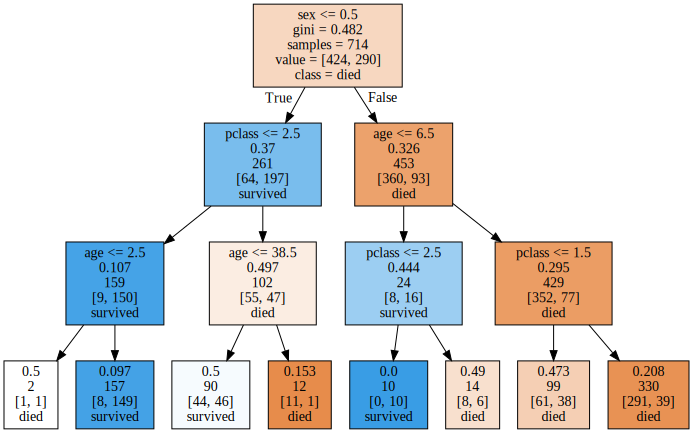

In [33]:
dot_data = export_graphviz(
    decision_tree, feature_names=features.feature,
    class_names=['died', 'survived'],
    label='root', filled=True, out_file=None) 
graph = graphviz.Source(dot_data) 
graph